In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

In [3]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv',
                        sep=',', parse_dates=['Date'], dayfirst=False, index_col='Date')

energy_df = energy_df[energy_df.id == 2]
energy_df = energy_df['2010-01-01':'2015-05-13']
energy_df.dropna(axis=1, inplace=True)

energy_ts = energy_df.EnergyConsumption

In [4]:
holt = Holt(sunspot_ts.values).fit()
holt.predict(len(sunspot_ts.values), len(sunspot_ts.values))

C:\Users\rusrom.EUROPE\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


array([169.00894991])

In [5]:
def get_density_forecast(ts, horizon, base_alg, base_params={}, bins='auto', fittedvalues=False):
    """
    Returns a list of density dictionaries {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    horizon : int
        The horizon to forecast.
    base_alg : {ExponentialSmoothing, SimpleExpSmoothing, Holt}
        The name of base algoritm for making density forecast.
    base_params : dict
        A Dictionary with base algorithm parameters.
    bins: int or sequence of scalars or str, optional
        Define how to calculate bins.
    fittedvalues: bool
        Include fitted values in density dictionaries or not.
    """
    
    # my experiment 
    if type(bins) == int:
        min_bound = int(np.floor(min(ts)))
        max_bound = int(np.ceil(max(ts)))
        bins = np.linspace(min_bound, max_bound, bins + 1)
        
    
    alg = base_alg(ts, **base_params).fit()
    
    if fittedvalues:
        alg_preds = alg.predict(start=0, end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(len(ts) + horizon)]
    else:
        alg_preds = alg.predict(start=len(ts), end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(horizon)]
    
    for i in range(len(alg_preds)):
        density_dicts[i]['dotted_forecast'] = alg_preds[i]
        
        current_density = alg.resid + alg_preds[i]
        density_dicts[i]['probs'], density_dicts[i]['bins'] = np.histogram(current_density, bins=bins, density=True)
    
    return density_dicts

In [6]:
def plot_density_forecast(ts, delay, base_alg, ax=None, **kwargs):
        
    density_dict = get_density_forecast(ts, delay, base_alg, **kwargs)[delay - 1]

    left_edges = density_dict['bins'][:-1]

    colors = []
    for i in range(len(left_edges) - 1):
        if left_edges[i] < density_dict['dotted_forecast'] < left_edges[i+1]:
            colors.append('coral')
        else:
            colors.append('royalblue')
    
    alg_name = str(base_alg)[str(base_alg).find('model.') + 6:-2]
    
    if ax:
        ax.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        ax.set_title(f'{alg_name}: density forecast with delay={delay}')
    else:
        plt.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        plt.title(f'{alg_name}: density forecast with delay={delay}')

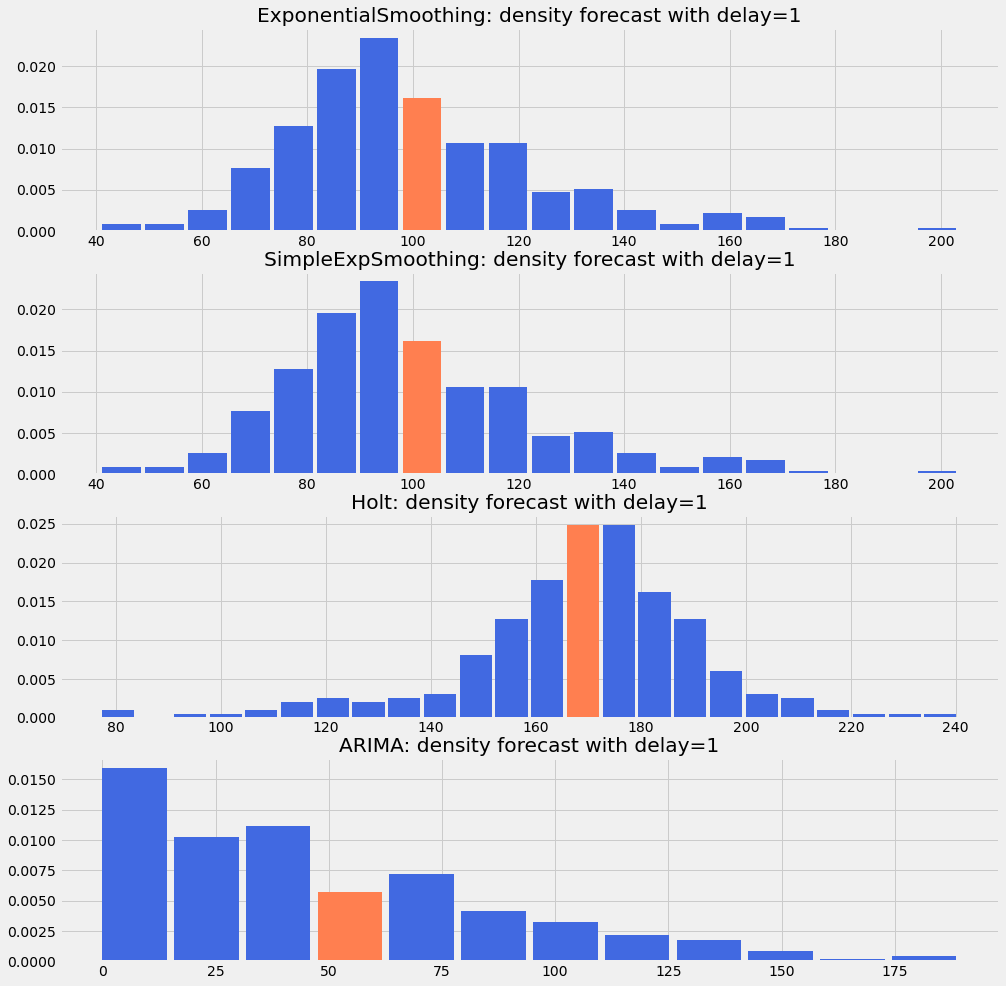

In [7]:
fig, ax = plt.subplots(4, figsize=(15,16))

for i, alg in enumerate([ExponentialSmoothing, SimpleExpSmoothing, Holt, ARIMA]):
    plot_density_forecast(sunspot_ts.values, 1, alg, ax=ax[i], bins='auto')

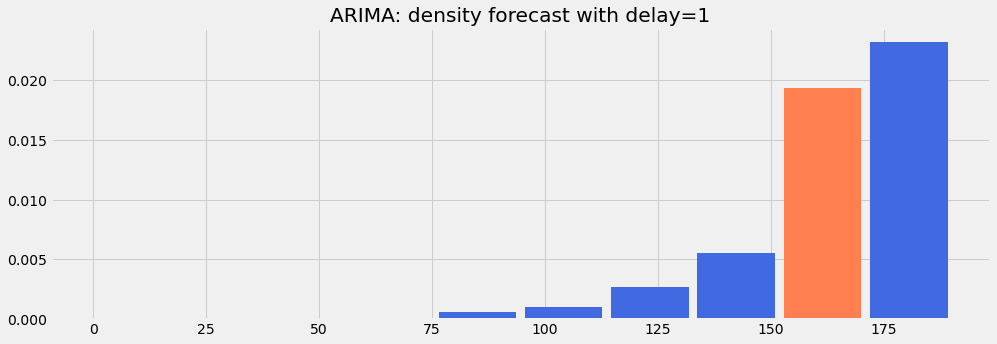

In [8]:
plt.figure(figsize=(15,5))
plot_density_forecast(sunspot_ts.values, 1, ARIMA, base_params={'order': (1, 2, 0)}, bins=10)

In [10]:
def brier_loss(y_true, density_dicts):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dicts : dict or array-like of dicts
        Dicts with bins and probabilities information.
    """
    T = len(ts)
    if type(density_dicts) == dict:
        density_dicts = [density_dicts]
#     Вынести лишний циклы в функции get_generalaized_loss / get_generalaized_loss
    brier_losses = [np.nan] * len(density_dicts)
    
    for density_dict_count, density_dict in enumerate(density_dicts):
        bins_number = density_dict['probs'].size
        bins_true = [0] * bins_number

        for i in range(bins_number):
            if density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]:
                bins_true[i] = 1

#         if np.sum(bins_true) == 0:
#             raise NotImplementedError('The y_true outside the range of bins boundaries')
# ок ли так же считать, если реальное значение не входит в прогнозные бины?
            
        brier_losses[density_dict_count] = np.sum(tbd* (density_dict['probs'] - bins_true)**2)
        
    return np.array(brier_losses)

In [11]:
def avoid_overflowing(base, power_array):
    maximum = np.max(power_array)
    minimum = np.min(power_array)
    
    pmax = -np.log(base)/np.log(2) * maximum
    pmin = -np.log(base)/np.log(2) * minimum
    
    if np.abs(pmax-pmin) > 2097:
        print('Overflow is imminent. Further calculations are not advised')
        return base ** power_array
    power_shift = abs((51+pmin+pmax)/2)
    power_shift = power_shift + min(0, pmin - power_shift + 1023)
    
    power_array = power_array - np.abs(power_shift * np.log(2) / np.log(base))
    
    return base ** power_array

In [31]:
def get_generalized_prediction(ts, preds, weights, loss_function, eta=1):
    generalized_predictions = []
    
    # my experiment 
    min_w = (preds[0]['bins'][0] + preds[0]['bins'][1]) / 2
    max_w = (preds[0]['bins'][-2] + preds[0]['bins'][-1]) / 2

    
#     min_w = int(np.floor(min(ts)))
#     max_w = int(np.ceil(max(ts)))
    
    for w in np.linspace(min_w, max_w, preds[0]['bins'].size - 1):
        losses = loss_function(w, preds)
        print(losses)
        exp_losses = avoid_overflowing(np.e, -eta * losses)
        generalized_predictions.append(-(1 / eta) * np.log(np.sum(weights * exp_losses)))
        
    return np.array(generalized_predictions)

In [32]:
losses = brier_loss(20, BA_preds[:, 0])
weights = np.full(2, 1/2)
# losses, weights

generalized_predictions = get_generalized_prediction(ts, BA_preds[:, 0], weights, brier_loss, eta=1)
generalized_predictions

[0.93043565 0.92672353]
[0.94140027 0.95915049]
[0.96004011 0.9659061 ]
[0.98745163 0.98617295]
[0.99183748 0.9888752 ]
[0.99951271 0.99292857]
[1.00060917 0.99833306]
[1.00280209 0.99427969]
[1.00170563 1.00103531]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00103531]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]
[1.00280209 1.00238643]


array([19.53241057, 19.57576448, 19.60119501, 19.64887749, 19.65596468,
       19.66768896, 19.67419468, 19.67232581, 19.67799398, 19.6804416 ,
       19.6804416 , 19.67909011, 19.6804416 , 19.6804416 , 19.6804416 ,
       19.6804416 , 19.6804416 , 19.6804416 , 19.6804416 , 19.6804416 ])

In [51]:
from scipy.optimize import fsolve

def s_equation(s, generalized_predictions, m = 2):
#     x = s - generalized_predictions
#     for i in range(len(x)):
#         x[i] = max(x[i], 0)
    return np.sum([max(i,0) for i in s - generalized_predictions]) - m

In [38]:
def substitution_function(generalized_predictions, s):
#     real_predictions = 
#     for prediction in real_predictions:
#         prediction = max(prediction, 0) / 2
#     return real_predictions
    return [max(i,0)/2 for i in s - generalized_predictions]

In [16]:
def update_weights(weights, losses, eta=1):
    exp_losses = avoid_overflowing(np.e, -eta * losses)
    new_weights = weights * exp_losses
    return new_weights / (np.sum(new_weights))

In [53]:
generalized_predictions = np.linspace(1, 1000, 1000)/np.pi
ans = fsolve(s_equation, max(generalized_predictions), args=generalized_predictions, m = 10)
s_equation(ans, generalized_predictions, m = 10)

TypeError: fsolve() got an unexpected keyword argument 'm'

In [17]:
def aggregating_algorithm(ts, delay, base_alg_dict, loss_function=brier_loss, weights=None, eta=1):
    """
    Returns density dictionary {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    delay : int
        The delay to forecast.
    base_alg_dict : dict
        The dictionary with the names of base algoritms and their params:
        base_alg {ExponentialSmoothing, SimpleExpSmoothing, Holt} - name of base algorithm.
        base_alg_params : dict - a dictionary of base algorithm's parameters.
    loss_function : function
        The loss function of aggregating algorithm.
    """
    T = len(ts)
    K = len(base_alg_dict)
    
    AA_preds = [{}] * (T + delay)
    BA_preds = np.array([{}] * (T + delay) * K).reshape(K, T + delay) 
    
    if not weights:
        weights = np.full(K, 1/K)
    
    i = 0
    for base_alg, base_alg_params in base_alg_dict.items():
        BA_preds[i] = get_density_forecast(ts, delay, base_alg, base_params=base_alg_params, fittedvalues=True)
        i += 1
        
    losses, prev_losses = None, None
        
    for t in range(T):
        preds = BA_preds[:, t]
        
        if not prev_losses:     
            prev_losses = loss_function(ts[t], preds)  # cheat
         
        # TBD: Рассчитать Omega (включая на базе ts и прогнозов BA)
        # TBD: обеспечить, что все BA имеют одинаковую Omega
        # TBD: Omega может динамически менять (расти)         
        generalized_predictions = get_generalized_prediction(ts[:t], preds, weights, loss_function, eta)
        
        #solving the equation to find s
        s_init = np.max(generalized_predictions)
        s = fsolve(s_equation, s_init, args=generalized_predictions)
        
        #get real prediction with substitution function
        AA_preds[t]['bins'] = BA_preds[:, t][0]['bins']
        AA_preds[t]['probs']  = substitution_function(generalized_predictions, s)
        
        #update weights 
        losses = loss_function(ts[t], preds)
        weights = update_weights(weights, losses, eta)
        
        prev_losses = losses
        
    # forecast for delay
    
    return AA_preds

In [18]:
T = sunspot_ts.size
ts = sunspot_ts.values
delay = 3
K = 2

BA_preds = np.array([{}]*(T + delay)*K).reshape(K, T + delay) 

i = 0
for base_alg, base_alg_params in {Holt: {}, SimpleExpSmoothing: {}}.items():
    BA_preds[i] = get_density_forecast(ts, delay, base_alg, base_params=base_alg_params, bins=20, fittedvalues=True)
    i += 1

C:\Users\rusrom.EUROPE\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [20]:
BA_preds[:, 0][0]['probs']

array([0.03618322, 0.03070091, 0.02138099, 0.00767523, 0.00548231,
       0.00164469, 0.00109646, 0.        , 0.00054823, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [21]:
losses = brier_loss(20, BA_preds[:, 0])
weights = np.full(2, 1/2)
losses, weights

(array([0.96004011, 0.9659061 ]), array([0.5, 0.5]))

In [26]:
BA_preds[:, 0][1]

0.10471204188481675

In [22]:
losses = brier_loss(20, BA_preds[:, 0])
weights = np.full(2, 1/2)
losses, weights

generalized_predictions = get_generalized_prediction(ts, BA_preds[:, 0], weights, brier_loss, eta=1)
generalized_predictions

array([19.53241057, 19.57576448, 19.60119501, 19.64887749, 19.65596468,
       19.66768896, 19.67419468, 19.67232581, 19.67799398, 19.6804416 ,
       19.6804416 , 19.67909011, 19.6804416 , 19.6804416 , 19.6804416 ,
       19.6804416 , 19.6804416 , 19.6804416 , 19.6804416 , 19.6804416 ])

In [33]:
s_init = np.max(generalized_predictions)
s = fsolve(s_equation, s_init, args=generalized_predictions)
s

array([19.75949609])

In [39]:
pr = substitution_function(generalized_predictions, s)
pr

[0.11354276020479048,
 0.09186580729929439,
 0.07915053851266762,
 0.05530930203040718,
 0.051765702821043647,
 0.04590356502118986,
 0.042650702558615805,
 0.04358514172006167,
 0.040751053143196714,
 0.03952724371191252,
 0.03952724371191252,
 0.040202989569589676,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252,
 0.03952724371191252]

In [26]:
np.sum(BA_preds[:, 0][0]['bins'][1] * pr)

9.550000000000242

In [40]:
sum(pr)

0.9999999999999822